In this notebook, based on the insights from the previous notebook i.e. RealPrice+FullInfo, we try to predict the Day Ahead prices. Day Ahead prices are essentially the price of a future contract maturing the next day. While day ahead prices are quoted ~ 70% times more than the real time prices, the real time prices have the ability to spike real bad.

## Data Processing

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,  mean_absolute_percentage_error

In [ ]:
!gdown #downloaded the data here

In [ ]:
#Lets load the data
df = pd.read_excel('/content/Test Project Ercot.xlsx',sheet_name='DataSet')

In [ ]:
#Lets remove some redundant features
df.drop('MARKETDAY',axis=1,inplace=True) #Already captured
df.drop('MONTH',axis=1,inplace=True)     #Already captured
df.drop('PEAKTYPE',axis=1,inplace=True)  #Empty
df.drop('DATETIME',axis=1,inplace=True)  #Already captured
df.drop('YEAR',axis=1,inplace=True)      #No point taking this as a feature

df.dropna(axis=0,how='any',inplace=True) #Dropping rows with NA values

In [ ]:
y_real=df[['HB_NORTH (RTLMP)']]
y_ahead=df[['HB_NORTH (DALMP)']]
X=df.drop(['HB_HOUSTON (RTLMP)','HB_NORTH (RTLMP)','HB_PAN (RTLMP)','HB_SOUTH (RTLMP)','HB_WEST (RTLMP)',
           'HB_HOUSTON (DALMP)','HB_NORTH (DALMP)','HB_PAN (DALMP)','HB_SOUTH (DALMP)','HB_WEST (DALMP)'],axis=1)
lst = ['WZ_West (RTLOAD)','WZ_Southern (RTLOAD)','WZ_SouthCentral (RTLOAD)',
       'WZ_NorthCentral (RTLOAD)','WZ_North (RTLOAD)','WZ_Coast (RTLOAD)',
       'WZ_ERCOT (RTLOAD)','WZ_East (RTLOAD)','WZ_FarWest (RTLOAD)',
        'GR_COASTAL (WIND_RTI)','GR_ERCOT (WIND_RTI)','GR_NORTH (WIND_RTI)',
        'GR_PANHANDLE (WIND_RTI)','GR_SOUTH (WIND_RTI)','GR_WEST (WIND_RTI)',
        'ERCOT (GENERATION_SOLAR_RT)','ERCOT (AGG_DAM_ENERGY_SOLD)','ERCOT (AGG_DAM_ENERGY_BOUGHT)',
        'ERCOT (HSL_DA)','ERCOT (HSL_CD)','ERCOT (PHYS_RESP_CAP)','ERCOT (RT_OR_PRADDER)',
        'ERCOT (RT_ORD_PRADDER)']
X_future = X.drop(lst,axis=1,inplace=False)
past_list = list(X_future.columns)
past_list.remove('day')
past_list.remove('month')
past_list.remove('HOURENDING')
X_past = X.drop(past_list,axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_y_DA,sc_y_real, sc_fut, sc_past = StandardScaler(), StandardScaler(), StandardScaler(), StandardScaler()
X_future = pd.DataFrame(sc_fut.fit_transform(X_future),index=X_future.index,columns=X_future.columns)
X_past = pd.DataFrame(sc_past.fit_transform(X_past),index=X_past.index,columns=X_past.columns)
y_ahead = pd.DataFrame(sc_y_DA.fit_transform(y_ahead),index=y_ahead.index,columns=y_ahead.columns)
y_real = pd.DataFrame(sc_y_real.fit_transform(y_real),index=y_real.index,columns=y_real.columns)

In [ ]:
X_future.shape

(4218, 27)

## Simple Features -Linear Regression

### Utils

In [ ]:
#Lets do a simple naive baseline where we simply use the X_future to predict the DayAhead prices and nothing else

#Some helper functions
months=[10,11,12,1,2,3]
months_scaled = X_future['month'].unique().tolist()

months_name=['Oct','Nov','Dec','Jan','Feb','Mar']

def evaluate(months, regressor, X, y, y_scaled=False,scaler=None, X_pca=None):
    if y_scaled:
        assert scaler is not None
    X_=None
        
    MSE_train=[]
    MSE_test=[]
    MAE_train=[]
    MAE_test=[]
    
    for month in months:
        if X_ is not None:
            X=X_
        
        ind_test = X.index[abs(X['month']-month)<=10e-3].tolist()
        ind_train = X.index[abs(X['month']-month)>10e-3].tolist()
        
        if X_pca is not None:
            X_=X
            X=X_pca
        
        X_train, X_test, y_train, y_test = X.loc[ind_train], X.loc[ind_test], y.loc[ind_train], y.loc[ind_test]
        regressor.fit(X_train,y_train)
        
        y_pred_train=regressor.predict(X_train)
        y_pred=regressor.predict(X_test)
        
        
        if y_scaled:
            y_train=scaler.inverse_transform(y_train)
            y_test = scaler.inverse_transform(y_test)
            y_pred_train = scaler.inverse_transform(y_pred_train.reshape(-1,1))
            y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
            
            
        MSE_train.append(round(mean_squared_error(y_train,y_pred_train),2))
        MAE_train.append(round(mean_absolute_error(y_train,y_pred_train),2))
        MSE_test.append(round(mean_squared_error(y_test,y_pred),2))
        MAE_test.append(round(mean_absolute_error(y_test,y_pred),2))
        
    plt.plot(months_name,MSE_train,label='MSE train')
    plt.plot(months_name,MAE_train,label='MAE train')
    plt.plot(months_name,MSE_test,label='MSE test')
    plt.plot(months_name,MAE_test,label='MAE test')
    plt.legend()
    plt.show()
    print('MSE_train',MSE_train, 'avg:', round(sum(MSE_train)/len(MSE_train),2))
    print('MSE_test',MSE_test,'avg:', round(sum(MSE_test)/len(MSE_train),2))
    print('MAE_train',MAE_train,'avg:', round(sum(MAE_train)/len(MSE_train),2))
    print('MAE_test',MAE_test,'avg:', round(sum(MAE_test)/len(MSE_train),2))
    

### Main

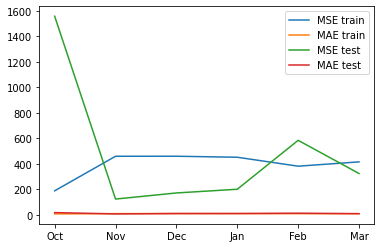

MSE_train [188.83, 459.55, 459.71, 451.83, 381.77, 415.57] avg: 392.88
MSE_test [1556.78, 124.1, 171.99, 200.99, 584.48, 324.4] avg: 493.79
MAE_train [7.87, 10.04, 10.24, 9.99, 9.54, 9.06] avg: 9.46
MAE_test [18.05, 7.73, 10.92, 11.05, 13.25, 9.86] avg: 11.81


In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
evaluate(months_scaled,reg,X_future,y_ahead,y_scaled=True,scaler=sc_y_DA)
# Seems easier to predict than real time prices, MSE is not super high,
# Hence targets are more stable

## Simple Features- Support Vector Regression

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

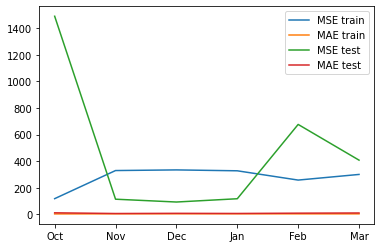

MSE_train [118.49, 329.88, 334.68, 327.98, 258.19, 300.64] avg: 278.31
MSE_test [1490.25, 114.4, 93.19, 117.86, 676.67, 408.04] avg: 483.4
MAE_train [3.73, 4.54, 4.8, 4.68, 4.22, 4.2] avg: 4.36
MAE_test [12.06, 6.78, 8.1, 7.12, 9.34, 10.74] avg: 9.02


In [ ]:
#Lets try to improve this baseline by using SVR- one of the better performing methods
#for real time price prediction
from sklearn import svm
svr1= svm.SVR(kernel='rbf',degree=1,C=0.6,gamma='scale',epsilon=0.05)
evaluate(months_scaled, svr1, X_future, y_ahead, y_scaled=True, scaler=sc_y_DA)
#Definitely a bit of improvement

## Simple Features- Neural Network w/ Data Augementation

### Utils

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
months=[10,11,12,1,2,3]
months_scaled = X_future['month'].unique().tolist()

months_name=['Oct','Nov','Dec','Jan','Feb','Mar']
target_months_name=['Jan','Feb','Mar']

In [ ]:
#Modified helper functions


def evaluateNN(months, X, y, y_scaled=False,scaler=None,aug=False,X_original=None,y_original=None,input_dim=27,do_return=False,backtest=False):
    if y_scaled:
        assert scaler is not None
    if aug:
        assert X_original is not None
        assert y_original is not None
        
    MSE_train=[]
    MSE_test=[]
    MAE_train=[]
    MAE_test=[]
    
    target_months = months[3:]

    if backtest is False:
        network = MyDNN(input_dim)
        network=network.to(dev)
        trainer = MyDNNTrain(network)

        ind_test = X.index[X['month']<0].tolist()
        ind_train = X.index[X['month']>0].tolist()
        X_train, X_test, y_train, y_test = np.array(X.loc[ind_train]), np.array(X.loc[ind_test]), np.array(y.loc[ind_train]), np.array(y.loc[ind_test])
        if aug:
            ind_original_test = X_original.index[X_original['month']<0].tolist()
            X_test = np.array(X_original.loc[ind_original_test])
            y_test = np.array(y_original.loc[ind_original_test])
        trainer.train(y_train,X_train)
        with torch.no_grad():
            y_pred_train=network.predict(X_train)
            y_pred=network.predict(X_test)
            
            if y_scaled:
                y_train=scaler.inverse_transform(y_train)
                y_test = scaler.inverse_transform(y_test)
                y_pred_train = scaler.inverse_transform(y_pred_train)
                y_pred = scaler.inverse_transform(y_pred)

        MSE_train.append(round(mean_squared_error(y_train,y_pred_train),2))
        MAE_train.append(round(mean_absolute_error(y_train,y_pred_train),2))
        MSE_test.append(round(mean_squared_error(y_test,y_pred),2))
        MAE_test.append(round(mean_absolute_error(y_test,y_pred),2))


    else:
        y_pred_final=[]
        for i,month in enumerate(target_months):
            network = MyDNN(input_dim)
            network=network.to(dev)
            trainer = MyDNNTrain(network)

            ind_test = X.index[(X['month']==month)].tolist()
            ind_train = X.index[(X['month']<month) | (X['month']>=0)].tolist()
        
            X_train, X_test, y_train, y_test = np.array(X.loc[ind_train]), np.array(X.loc[ind_test]), np.array(y.loc[ind_train]), np.array(y.loc[ind_test])

            if aug:
                ind_original_test = X_original.index[(X_original['month']==month)].tolist()
                X_test = np.array(X_original.loc[ind_original_test])
                y_test = np.array(y_original.loc[ind_original_test])

            trainer.train(y_train,X_train)
                
            with torch.no_grad():
                y_pred_train=network.predict(X_train)
                y_pred=network.predict(X_test)
                    
                    
                if y_scaled:
                    y_train=scaler.inverse_transform(y_train)
                    y_test = scaler.inverse_transform(y_test)
                    y_pred_train = scaler.inverse_transform(y_pred_train)
                    y_pred = scaler.inverse_transform(y_pred)
                        
                        
                MSE_train.append(round(mean_squared_error(y_train,y_pred_train),2))
                MAE_train.append(round(mean_absolute_error(y_train,y_pred_train),2))
                MSE_test.append(round(mean_squared_error(y_test,y_pred),2))
                MAE_test.append(round(mean_absolute_error(y_test,y_pred),2))
            
            y_pred_final.append(y_pred)
        
    # plt.plot(months_name,MSE_train,label='MSE train')
    # plt.plot(months_name,MAE_train,label='MAE train')
    # plt.plot(months_name,MSE_test,label='MSE test')
    # plt.plot(months_name,MAE_test,label='MAE test')
    # plt.legend()
    # plt.show()
    print('MSE_train',MSE_train, 'avg:', round(sum(MSE_train)/len(MSE_train),2))
    print('MSE_test',MSE_test,'avg:', round(sum(MSE_test)/len(MSE_train),2))
    print('MAE_train',MAE_train,'avg:', round(sum(MAE_train)/len(MSE_train),2))
    print('MAE_test',MAE_test,'avg:', round(sum(MAE_test)/len(MSE_train),2))

    if do_return:
        if backtest is False:
            return y_pred
        else:
            return np.concatenate(y_pred_final,axis=0)
    
class MyDataset(Dataset):
    def __init__(self, labels, features):
        super(MyDataset, self).__init__()
        self.labels = labels
        self.features = features

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return {'feature': feature, 'label': label}

class MyDNN(nn.Module):
    def __init__(self, input_dim):
        super(MyDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 70)
        self.fc2 = nn.Linear(70, 35)
        self.fc3 = nn.Linear(35, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
	
    def predict(self, features):
        self.eval()	
        features = torch.from_numpy(features).float().to(dev)
        return self.forward(features).detach().to('cpu').numpy()

class MyDNNTrain(object): 
    def __init__(self, network):
        self.network = network
        self.learning_rate = .0001
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=self.learning_rate,weight_decay=1e-6)
        self.criterion = nn.MSELoss()
        self.num_epochs = 200
        self.batchsize = 100
        self.shuffle = True
        self.dev=dev

    def train(self, labels, features):
        self.network.train()
        dataset = MyDataset(labels, features)
        loader = DataLoader(dataset, shuffle=self.shuffle, batch_size = self.batchsize)
        for epoch in range(self.num_epochs):
            self.train_epoch(loader, epoch)

    def train_epoch(self, loader, epoch):
        total_loss = 0.0
        for i, data in enumerate(loader):
            features = data['feature'].float().to(dev)
            labels = data['label'].float().to(dev)
            self.optimizer.zero_grad()
            predictions = self.network(features)
            loss = self.criterion(predictions, labels)
            loss.backward()
            total_loss += loss.item()
            self.optimizer.step()
        #print( 'Epoch',epoch,'loss', total_loss/i)

###Main

In [ ]:
Xnp = np.array(X_future)
n = Xnp.shape[0]
D=Xnp.shape[1]
X_aug=np.ones((1,D))
y_aug=np.ones(1)
indexes=[]
random.seed(0)
for i in range(10000):
    ind = random.randint(0,n)
    indexes.append(ind)
    y_aug=np.vstack((y_aug,y_ahead.iloc[ind]))
    x = Xnp[ind,:]
    x[:D-3]=x[:D-3]+np.random.normal(0,0.1,(D-3,))
    X_aug=np.vstack((X_aug,x))
X_aug=pd.DataFrame(X_aug[1:,:],columns=X_future.columns)
y_aug=pd.DataFrame(y_aug[1:,:],columns=y_ahead.columns)

In [ ]:
# Concatenating new dataset with augmentations
X_new=pd.concat([X_future,X_aug])
y_new=pd.concat([y_ahead,y_aug])

random.seed(0)

# print('without regularization & backtesting:')
# evaluateNN(months_scaled,X_future,y_ahead,y_scaled=True,scaler=sc_y_DA,aug=False,X_original=X_future,y_original=y_ahead,backtest=True)
# print('without regularization & no backtesting:')
# evaluateNN(months_scaled,X_future,y_ahead,y_scaled=True,scaler=sc_y_DA,aug=False,X_original=X_future,y_original=y_ahead,backtest=False)
print('with regularization & backtesting:')
out1=evaluateNN(months_scaled,X_new,y_new,y_scaled=True,scaler=sc_y_DA,aug=True,X_original=X_future,y_original=y_ahead,do_return= True,backtest=True)
# print('with regularization & no backtesting:')
# out2=evaluateNN(months_scaled,X_new,y_new,y_scaled=True,scaler=sc_y_DA,aug=True,X_original=X_future,y_original=y_ahead,do_return= True,backtest=False)

with regularization & backtesting:
MSE_train [22.98, 19.63, 16.62] avg: 19.74
MSE_test [32.3, 51.86, 59.57] avg: 47.91
MAE_train [3.24, 2.94, 2.83] avg: 3.0
MAE_test [3.86, 4.56, 4.63] avg: 4.35
